In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F

import matplotlib.pyplot as plt

from trainer.utils import resize, random_flip
# from trainer.encoder import DataEncoder

import os
import numpy as np
import pandas as pd
import cv2

from PIL import Image
from albumentations import (
    CLAHE,
    Blur,
    OneOf,
    Compose,
    RGBShift,
    GaussNoise,
    RandomGamma,
    RandomContrast,
    RandomBrightness,
)

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import HueSaturationValue
from albumentations.augmentations.transforms import Normalize
from albumentations import Resize


/home/rahul/.conda/envs/opcv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
from typing import Callable, Iterable
from dataclasses import dataclass

from torchvision.transforms import ToTensor


@dataclass
class SystemConfig:
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = False  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)


@dataclass
class DatasetConfig:
    root_dir: str = "data"  # dataset directory root
    train_transforms: Iterable[Callable] = (
        ToTensor(),
    )  # data transformation to use during training data preparation
    test_transforms: Iterable[Callable] = (
        ToTensor(),
    )  # data transformation to use during test data preparation


@dataclass
class DataloaderConfig:
    batch_size: int = 250  # amount of data to pass through the network at each forward-backward iteration
    num_workers: int = 5  # number of concurrent processes using to prepare data


@dataclass
class OptimizerConfig:
    learning_rate: float = 0.001  # determines the speed of network's weights update
    momentum: float = 0.9  # used to improve vanilla SGD algorithm and provide better handling of local minimas
    weight_decay: float = 0.0001  # amount of additional regularization on the weights values
    lr_step_milestones: Iterable = (
        30, 40
    )  # at which epoches should we make a "step" in learning rate (i.e. decrease it in some manner)
    lr_gamma: float = 0.1  # multiplier applied to current learning rate at each of lr_ctep_milestones


@dataclass
class TrainerConfig:
    model_dir: str = "checkpoints"  # directory to save model states
    model_save_best: bool = True  # save model with best accuracy
    model_saving_frequency: int = 1  # frequency of model state savings per epochs
    device: str = "cpu"  # device to use for training.
    epoch_num: int = 50  # number of times the whole dataset will be passed through the network
    progress_bar: bool = False  # enable progress bar visualization during train process


In [3]:
class ListDataset(Dataset):
    def __init__(self, root_dir, data_dir, list_file, classes, mode, transform, input_size):
        '''
        Args:
          root_dir: (str) ditectory to images.
          list_file: (str) path to index file.
          train: (boolean) train or test.
          transform: ([transforms]) image transforms.
          input_size: (int) model input size.
        '''
        self.root_dir = root_dir
        self.data_dir = data_dir
        self.classes = classes
        self.mode = mode
        self.transform = transform
        self.input_size = input_size

        self.fnames = []
        self.boxes = []
        self.labels = []

        list_file_path = os.path.join(root_dir, list_file)
        with open(list_file_path) as f:
            lines = f.readlines()
            self.num_samples = len(lines)

        for line in lines:
            splited = line.strip().split()
            self.fnames.append(splited[0])
            num_boxes = (len(splited) - 1) // 5
            box = []
            label = []
            for i in range(num_boxes):
                xmin = splited[1 + 5 * i]
                ymin = splited[2 + 5 * i]
                xmax = splited[3 + 5 * i]
                ymax = splited[4 + 5 * i]
                class_label = splited[5 + 5 * i]
                box.append([float(xmin), float(ymin), float(xmax), float(ymax)])
                label.append(int(class_label))
            self.boxes.append(torch.Tensor(box))
            self.labels.append(torch.LongTensor(label))


    def __getitem__(self, idx):
        '''Load image.

        Args:
          idx: (int) image index.

        Returns:
          img: (tensor) image tensor.
          loc_targets: (tensor) location targets.
          cls_targets: (tensor) class label targets.
        '''
        # Load image and boxes.
        path = os.path.join(self.root_dir, self.data_dir, self.fnames[idx])
        img = cv2.imread(path)
        if img is None or np.prod(img.shape) == 0:
            print('cannot load image from path: ', path)
            sys.exit(-1)

        img = img[..., ::-1]

        boxes = self.boxes[idx].clone()
        boxes = self.boxes[idx]
        labels = self.labels[idx]
        size = self.input_size

        # Resize & Flip
        img, boxes = resize(img, boxes, (size, size))
        if self.mode == 'train':
            img, boxes = random_flip(img, boxes)
        # Data augmentation.
        img = np.array(img)
        if self.transform:
            img = self.transform(image=img)['image']

        batch = (img, boxes, labels)


        return img, boxes, labels

    # def collate_fn(self, batch):
    #     '''Pad images and encode targets.

    #     As for images are of different sizes, we need to pad them to the same size.

    #     Args:
    #       batch: (list) of images, cls_targets, loc_targets.

    #     Returns:
    #       padded images, stacked cls_targets, stacked loc_targets.
    #     '''
    #     imgs = [x[0] for x in batch]
    #     boxes = [x[1] for x in batch]
    #     labels = [x[2] for x in batch]

    #     h = w = self.input_size
    #     num_imgs = len(imgs)
    #     inputs = torch.zeros(num_imgs, 3, w, h)
    #     encoder = DataEncoder((w, h))
    #     loc_targets = []
    #     cls_targets = []
    #     for i in range(num_imgs):
    #         inputs[i] = imgs[i]
    #         loc_target, cls_target = encoder.encode(boxes[i], labels[i])
    #         loc_targets.append(loc_target)
    #         cls_targets.append(cls_target)
    #     return inputs, torch.stack(loc_targets), torch.stack(cls_targets)

    def __len__(self):
        return self.num_samples

In [4]:
def patch_configs(epoch_num_to_set=TrainerConfig.epoch_num, batch_size_to_set=DataloaderConfig.batch_size):
    """ Patches configs if cuda is not available

    Returns:
        returns patched dataloader_config and trainer_config

    """
    # default experiment params
    num_workers_to_set = DataloaderConfig.num_workers

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 1

    dataloader_config = DataloaderConfig(batch_size=batch_size_to_set, num_workers=num_workers_to_set)
    trainer_config = TrainerConfig(device=device, epoch_num=epoch_num_to_set, progress_bar=True)
    return dataloader_config, trainer_config

In [5]:
dataloader_config, trainer_config = patch_configs(epoch_num_to_set=10, batch_size_to_set=1)
dataset_config = DatasetConfig(
    root_dir="../../../Datasets/Road_Scene_Object_Detection",
    train_transforms=[
#         Normalize(),
        Resize(height=300, width=300),
        ToTensorV2()
    ]
)

In [6]:
dataset_train = ListDataset(
    root_dir=dataset_config.root_dir,
    data_dir = 'export',
    list_file='annots_converted_train.txt',

    classes=[
        "__background__",
        "biker",
        "car",
        "pedestrian",
        "trafficLight",
        "trafficLight-Green",
        "trafficLight-GreenLeft",
        "trafficLight-Red",
        "trafficLight-RedLeft",
        "trafficLight-Yellow",
        "trafficLight-YellowLeft",
        "truck"
    ],
    mode='train',
    transform=Compose(dataset_config.train_transforms),
    input_size=300
)

loader_train = DataLoader(
    dataset=dataset_train,
    batch_size=dataloader_config.batch_size,
    shuffle=True,
#     collate_fn=dataset_train.collate_fn,
    num_workers=dataloader_config.num_workers,
    pin_memory=True
)

In [7]:
classes_dict = {
        0:"biker",
        1:"car",
        2:"pedestrian",
        3:"trafficLight",
        4:"trafficLight-Green",
        5:"trafficLight-GreenLeft",
        6:"trafficLight-Red",
        7:"trafficLight-RedLeft",
        8:"trafficLight-Yellow",
        9:"trafficLight-YellowLeft",
        10:"truck",
}

In [8]:
def convert_img_tensor_to_numpy(torch_tensor):
    # Convert PyTorch tensor to NumPy array
    numpy_image = torch_tensor.numpy()

    # Convert to uint8 and transpose if necessary
    if numpy_image.dtype != np.uint8:
        numpy_image = (numpy_image * 255).astype(np.uint8)

    # If image is in CHW format (channels, height, width), transpose it to HWC format (height, width, channels)
    if numpy_image.shape[0] == 3:  # If channels are the first dimension
        numpy_image = numpy_image.transpose(1, 2, 0)
        
    return numpy_image



In [9]:
def view_images(img_tensor, box, class_list):
    img = convert_img_tensor_to_numpy(img_tensor)
    box = box.numpy()
    class_list = class_list.numpy()
    for i in range(len(box)):
        x_min = int(box[i][0])
        y_min = int(box[i][1])
        x_max = int(box[i][2])
        y_max = int(box[i][3])
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
        cv2.putText(img, classes_dict[class_list[i]], (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    plt.figure(figsize=(12, 18))
    plt.imshow(img)
    plt.show()

In [10]:
class DataEncoder:
    def __init__(self, input_size):
        self.input_size = input_size
        self.anchor_areas = [8 * 8, 16 * 16., 32 * 32., 64 * 64., 128 * 128]  # p3 -> p7
        self.aspect_ratios = [0.5, 1, 2]
        self.scales = [1, pow(2, 1 / 3.), pow(2, 2 / 3.)]
        num_fms = len(self.anchor_areas)
        fm_sizes = [math.ceil(self.input_size[0] / pow(2., i + 3)) for i in range(num_fms)]
        self.anchor_boxes = []
        for i, fm_size in enumerate(fm_sizes):
            anchors = generate_anchors(self.anchor_areas[i], self.aspect_ratios, self.scales)
            anchor_grid = generate_anchor_grid(input_size, fm_size, anchors)
            self.anchor_boxes.append(anchor_grid)
        self.anchor_boxes = torch.cat(self.anchor_boxes, 0)
        self.classes = [
        "__background__",
        "biker",
        "car",
        "pedestrian",
        "trafficLight",
        "trafficLight-Green",
        "trafficLight-GreenLeft",
        "trafficLight-Red",
        "trafficLight-RedLeft",
        "trafficLight-Yellow",
        "trafficLight-YellowLeft",
        "truck"
        ]

    def encode(self, boxes, classes):
        iou = compute_iou(boxes, self.anchor_boxes)
        iou, ids = iou.max(1)
        loc_targets = encode_boxes(boxes[ids], self.anchor_boxes)
        cls_targets = classes[ids]
        cls_targets[iou < 0.5] = -1
        cls_targets[iou < 0.4] = 0

        return loc_targets, cls_targets

    def decode(self, loc_pred, cls_pred, cls_threshold=0.7, nms_threshold=0.3):
        all_boxes = [[] for _ in range(len(loc_pred))]  # batch_size

        for sample_id, (boxes, scores) in enumerate(zip(loc_pred, cls_pred)):
            boxes = decode_boxes(boxes, self.anchor_boxes)

            conf = scores.softmax(dim=1)
            sample_boxes = [[] for _ in range(len(self.classes))]
            for class_idx, class_name in enumerate(self.classes):
                if class_name == '__background__':
                    continue
                class_conf = conf[:, class_idx]
                ids = (class_conf > cls_threshold).nonzero().squeeze()
                ids = [ids.tolist()]
                keep = compute_nms(boxes[ids], class_conf[ids], threshold=nms_threshold)

                conf_out, top_ids = torch.sort(class_conf[ids][keep], dim=0, descending=True)
                boxes_out = boxes[ids][keep][top_ids]

                boxes_out = boxes_out.cpu().numpy()
                conf_out = conf_out.cpu().numpy()

                c_dets = np.hstack((boxes_out, conf_out[:, np.newaxis])).astype(np.float32, copy=False)
                c_dets = c_dets[c_dets[:, 4].argsort()]
                sample_boxes[class_idx] = c_dets

            all_boxes[sample_id] = sample_boxes

        return all_boxes

    def get_num_anchors(self):
        return len(self.aspect_ratios) * len(self.scales)

In [21]:
def decode_boxes(deltas, anchors):
    if torch.cuda.is_available():
        anchors = anchors.cuda()
    anchors_wh = anchors[:, 2:] - anchors[:, :2] + 1
    anchors_ctr = anchors[:, :2] + 0.5 * anchors_wh
    pred_ctr = deltas[:, :2] * anchors_wh + anchors_ctr
    pred_wh = torch.exp(deltas[:, 2:]) * anchors_wh
    return torch.cat([pred_ctr - 0.5 * pred_wh, pred_ctr + 0.5 * pred_wh - 1], 1)


def encode_boxes(boxes, anchors):
    anchors_wh = anchors[:, 2:] - anchors[:, :2] + 1
    anchors_ctr = anchors[:, :2] + 0.5 * anchors_wh
    boxes_wh = boxes[:, 2:] - boxes[:, :2] + 1
    boxes_ctr = boxes[:, :2] + 0.5 * boxes_wh
    return torch.cat([(boxes_ctr - anchors_ctr) / anchors_wh, torch.log(boxes_wh / anchors_wh)], 1)


def generate_anchor_grid(input_size, fm_size, anchors):
    grid_size = input_size[0] / fm_size
    x, y = torch.meshgrid(torch.arange(0, fm_size) * grid_size, torch.arange(0, fm_size) * grid_size)
    anchors = anchors.view(-1, 1, 1, 4)
    xyxy = torch.stack([x, y, x, y], 2).float()
    boxes = (xyxy + anchors).permute(2, 1, 0, 3).contiguous().view(-1, 4)
    boxes[:, 0::2] = boxes[:, 0::2].clamp(0, input_size[0])
    boxes[:, 1::2] = boxes[:, 1::2].clamp(0, input_size[1])
    return boxes


def generate_anchors(anchor_area, aspect_ratios, scales):
    anchors = []
    for scale in scales:
        for ratio in aspect_ratios:
            h = round(math.sqrt(anchor_area) / ratio)
            w = round(ratio * h)
            x1 = (math.sqrt(anchor_area) - scale * w) * 0.5
            y1 = (math.sqrt(anchor_area) - scale * h) * 0.5
            x2 = (math.sqrt(anchor_area) + scale * w) * 0.5
            y2 = (math.sqrt(anchor_area) + scale * h) * 0.5
            anchors.append([x1, y1, x2, y2])
    return torch.Tensor(anchors)


def compute_iou(src, dst):
    p1 = torch.max(dst[:, None, :2], src[:, :2])
    p2 = torch.min(dst[:, None, 2:], src[:, 2:])
    inter = torch.prod((p2 - p1 + 1).clamp(0), 2)
    src_area = torch.prod(src[:, 2:] - src[:, :2] + 1, 1)
    dst_area = torch.prod(dst[:, 2:] - dst[:, :2] + 1, 1)
    iou = inter / (dst_area[:, None] + src_area - inter)
    return iou


def compute_nms(boxes, conf, threshold=0.5):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    _, order = conf.sort(0, descending=True)

    keep = []
    while order.numel() > 0:
        i = order[0] if order.numel() > 1 else order.item()
        keep.append(i)

        if order.numel() == 1:
            break

        xx1 = x1[order[1:]].clamp(min=x1[i].item())
        yy1 = y1[order[1:]].clamp(min=y1[i].item())
        xx2 = x2[order[1:]].clamp(max=x2[i].item())
        yy2 = y2[order[1:]].clamp(max=y2[i].item())

        w = (xx2 - xx1 + 1).clamp(min=0)
        h = (yy2 - yy1 + 1).clamp(min=0)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        ids = (ovr <= threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids + 1]
    return torch.LongTensor(keep)

In [22]:
dataset_train[0][0].shape

torch.Size([3, 300, 300])

In [23]:
dataset_train[0][1].shape

torch.Size([1, 4])

In [24]:
dataset_train[0][2].shape

torch.Size([1])

In [25]:
batch = []
for img_id in range(20):
    batch.append(dataset_train[img_id])

RuntimeError: The size of tensor a (0) must match the size of tensor b (4) at non-singleton dimension 0

In [38]:
dataset_train[18]

RuntimeError: The size of tensor a (0) must match the size of tensor b (4) at non-singleton dimension 0

In [26]:
len(batch)

18

In [27]:
import math

In [28]:
def collate_fn(batch):
    '''Pad images and encode targets.

    As for images are of different sizes, we need to pad them to the same size.

    Args:
      batch: (list) of images, cls_targets, loc_targets.

    Returns:
      padded images, stacked cls_targets, stacked loc_targets.
    '''
    imgs = [x[0] for x in batch]
    boxes = [x[1] for x in batch]
    labels = [x[2] for x in batch]

    h = w = 300
    num_imgs = len(imgs)
    inputs = torch.zeros(num_imgs, 3, w, h)
    encoder = DataEncoder((w, h))
    loc_targets = []
    cls_targets = []
    for i in range(num_imgs):
        inputs[i] = imgs[i]
        loc_target, cls_target = encoder.encode(boxes[i], labels[i])
        loc_targets.append(loc_target)
        cls_targets.append(cls_target)
    return inputs, torch.stack(loc_targets), torch.stack(cls_targets)

In [29]:
out = collate_fn(batch)

In [30]:
len(out)

3

In [31]:
len(out[0])

18

In [32]:
out[0][0].shape

torch.Size([3, 300, 300])

In [33]:
out[1][0].shape

torch.Size([17451, 4])

In [35]:
out[2].shape

torch.Size([18, 17451])

In [16]:
type(dataset_train)

__main__.ListDataset

In [17]:
dataset_train[0]

(tensor([[[ 25,  24,  26,  ..., 106, 137, 212],
          [ 26,  25,  25,  ...,  98, 118, 191],
          [ 22,  22,  25,  ...,  67, 203, 189],
          ...,
          [ 99,  91,  91,  ...,  23,  23,  22],
          [ 90,  96,  90,  ...,  22,  22,  22],
          [ 90,  90,  91,  ...,  22,  22,  22]],
 
         [[ 28,  28,  27,  ...,  94, 160, 220],
          [ 27,  26,  26,  ...,  71, 121, 185],
          [ 21,  21,  25,  ...,  53, 215, 187],
          ...,
          [100,  92,  92,  ...,  24,  24,  23],
          [ 91,  97,  91,  ...,  23,  23,  23],
          [ 91,  91,  92,  ...,  23,  23,  23]],
 
         [[ 22,  22,  24,  ..., 103, 154, 246],
          [ 28,  27,  24,  ...,  66, 111, 215],
          [ 22,  23,  24,  ...,  52, 214, 229],
          ...,
          [102,  94,  94,  ...,  28,  28,  27],
          [ 93,  99,  93,  ...,  27,  27,  27],
          [ 93,  93,  94,  ...,  27,  27,  27]]], dtype=torch.uint8),
 tensor([[234.8438, 121.0000, 299.8438, 204.5000]]),
 tensor([1

In [10]:
img_id = 500
view_images(dataset_train[img_id][0],dataset_train[img_id][1],dataset_train[img_id][2])

RuntimeError: The size of tensor a (2) must match the size of tensor b (298) at non-singleton dimension 2

In [11]:
img_id = 0
view_images(dataset_train[img_id][0],dataset_train[img_id][1],dataset_train[img_id][2])

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [12]:
iterator = iter(loader_train)
one_batch = next(iterator)

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/rahul/.conda/envs/opcv/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/rahul/.conda/envs/opcv/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/rahul/.conda/envs/opcv/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-3-654df3856654>", line 93, in __getitem__
    loc_target, cls_target = encoder.encode(boxes[i], labels[i])
  File "/media/rahul/a079ceb2-fd12-43c5-b844-a832f31d5a39/Projects/autonomous_cars/Object_Detector_for_road/SSD_Detector_for_road_training/SSD_Trainer/trainer/encoder.py", line 37, in encode
    iou = compute_iou(boxes, self.anchor_boxes)
  File "/media/rahul/a079ceb2-fd12-43c5-b844-a832f31d5a39/Projects/autonomous_cars/Object_Detector_for_road/SSD_Detector_for_road_training/SSD_Trainer/trainer/encoder.py", line 125, in compute_iou
    p2 = torch.min(dst[:, None, 2:], src[:, 2:])
RuntimeError: The size of tensor a (2) must match the size of tensor b (298) at non-singleton dimension 2


In [13]:
one_batch

[tensor([[[[120, 142, 241,  ...,  29,  35,  37],
           [ 98, 134, 237,  ...,  33,  63,  31],
           [ 71,  92, 198,  ...,  33,  54,  32],
           ...,
           [ 77,  78,  71,  ...,  75,  78,  76],
           [ 58,  57,  53,  ...,  79,  81,  80],
           [ 49,  52,  48,  ...,  82,  83,  79]],
 
          [[126, 135, 237,  ...,  29,  35,  37],
           [103, 131, 239,  ...,  33,  63,  31],
           [ 74,  94, 201,  ...,  33,  54,  32],
           ...,
           [ 78,  79,  72,  ...,  79,  84,  82],
           [ 58,  57,  54,  ...,  83,  87,  86],
           [ 48,  51,  48,  ...,  86,  89,  85]],
 
          [[112, 167, 253,  ...,  28,  33,  35],
           [ 89, 157, 227,  ...,  32,  61,  29],
           [ 64, 109, 184,  ...,  32,  52,  30],
           ...,
           [ 86,  87,  78,  ...,  80,  84,  82],
           [ 63,  63,  59,  ...,  84,  87,  86],
           [ 53,  56,  53,  ...,  87,  89,  85]]]], dtype=torch.uint8),
 tensor([[[   0.,  602.,  100.,  660.],
 

In [56]:
def view_images_loader(img_tensor, box, class_list):
    img = convert_img_tensor_to_numpy(img_tensor[0])
    box = box[0].numpy()
    class_list = class_list[0].numpy()
    for i in range(len(box)):
        x_min = int(box[i][0])
        y_min = int(box[i][1])
        x_max = int(box[i][2])
        y_max = int(box[i][3])
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
        cv2.putText(img, classes_dict[class_list[i]], (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    plt.figure(figsize=(12, 18))
    plt.imshow(img)
    plt.show()

In [57]:
view_images(one_batch[0][0], one_batch[1][0], one_batch[2][0])

TypeError: Expected Ptr<cv::UMat> for argument 'img'

In [60]:
img = convert_img_tensor_to_numpy(one_batch[0][0])

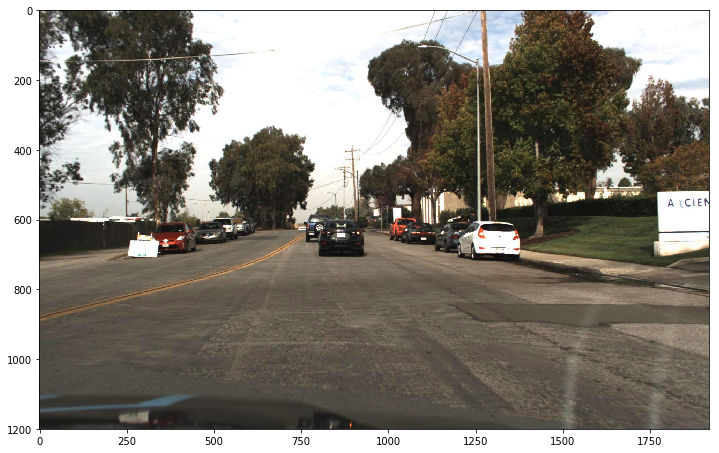

In [61]:
plt.figure(figsize=(12, 18))
plt.imshow(img)

In [86]:
one_batch[1]

tensor([[[ 306.,  598.,  458.,  714.],
         [ 438.,  600.,  536.,  680.],
         [ 504.,  588.,  574.,  664.],
         [ 748.,  572.,  830.,  682.],
         [ 782.,  586.,  962.,  718.],
         [ 790.,  590.,  938.,  706.],
         [ 996.,  584., 1042.,  672.],
         [1042.,  598., 1142.,  682.],
         [1114.,  588., 1204.,  710.],
         [1188.,  588., 1388.,  730.]]])